# Ditto Detector

## Import Requirements

In [1]:
import requests
from multiprocessing import Pool
import pandas as pd
from tqdm import tqdm
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import nmslib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Downloading The Files 

In [2]:
def download_images(csv_file):
    df = pd.read_csv(csv_file)
    files = df['images'].values
    if not os.path.exists('Images'):
        os.mkdir('Images')
        
    with Pool(10) as p:
        p.map(download_image, files)


def download_image(file_url):
    filename = 'Images/' + file_url.split('/')[-1]
    r = requests.get(file_url, allow_redirects=True)
    open(filename, 'wb').write(r.content)

In [3]:
download_images('local_back_robe_5000.csv')

## Image and Text Embeddings 

In [4]:

class ImageEmbedding:
  def __init__(self, params):
    self._img_size = params['IMAGE_SIZE']
    self._embeddings_model = hub.load(params['IMAGE_HUB_PATH'])

  def generate_embedding(self, file_path):
    file_path = file_path[0]
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, self._img_size)
    img = tf.expand_dims(img, axis=0)

    embedding = self._embeddings_model(img)
    embedding = tf.squeeze(embedding)
    return embedding

class TextEmbedding:
  def __init__(self, params):
    self._embeddings_model = hub.load(params['TEXT_HUB_PATH'])

  def generate_embedding(self, text_list):
    embedding = self._embeddings_model(text_list)
    embedding = tf.squeeze(embedding)
    return embedding

## Data Reader 

In [5]:

class Data:
    def __init__(self, params):
        self._csv_file = params['CSV_FILE']
        self._batch_size = params['BATCH_SIZE']

        self._image_embeddings = ImageEmbedding(params)
        self._text_embeddings = TextEmbedding(params)

        self.csv_ds = self._prepare_dataset()

    def _prepare_dataset(self):
        csv_ds = tf.data.experimental.make_csv_dataset(self._csv_file, batch_size=1)
        csv_ds = csv_ds.map(self._map_row)
        csv_ds = csv_ds.batch(self._batch_size) #, drop_remainder=True)
        # csv_ds = csv_ds.prefetch(10 * self._batch_size)
        return csv_ds

    def _map_row(self, row):
        img_path = row['local_images']
        text_desc = row['description']
        embedding = self.generate_sample_embedding(img_path, text_desc)

        return embedding, img_path, text_desc

    def generate_sample_embedding(self, img_path, text_desc):
        img_embedding = self._image_embeddings.generate_embedding(img_path)
        text_embedding = self._text_embeddings.generate_embedding(text_desc)
        embedding = tf.concat((img_embedding, text_embedding), axis=-1)
        return embedding

    def generate_embeddings(self, n_samples):
        mini_batches = n_samples // self._batch_size
        embeddings = []
        img_paths = []
        descriptions = []
        print('Reading input data.....')
        for e, i, d in tqdm(self.csv_ds.take(mini_batches)):
            embeddings.append(e)
            img_paths.append(i)
            descriptions.append(d)

        embeddings = np.concatenate(embeddings, axis=0)
        img_paths = np.concatenate(img_paths, axis=0)
        descriptions = np.concatenate(descriptions, axis=0)
        

        return embeddings, img_paths, descriptions

## Feature Space Clustering

In [6]:

class Cluster:
    def __init__(self, params):
        self._data = Data(params)
        self._threshold_at = params['THRESHOLD']
        n_samples = params['N_SAMPLES']
        embeddings, self._img_paths, self._descriptions = self._data.generate_embeddings(n_samples)

        self._data_index = self._create_data_index(embeddings)
        del embeddings
        
        

    def _create_data_index(self, embeddings):
        data_index = nmslib.init(method='hnsw', space='cosinesimil')
        data_index.addDataPointBatch(embeddings)
        data_index.createIndex({'post': 2}, print_progress=True)
        return data_index

    def get_nearest_neighbor(self, img_path, text_desc):
        sample_embedding = self._data.generate_sample_embedding(img_path, text_desc)
        ids, distances = self._data_index.knnQuery(sample_embedding, k=1)
        
        is_valid = distances[0] >= self._threshold_at
        ret_path, desc = '', ''
        if not is_valid:
            ret_path = self._img_paths[ids[0]]
            desc = self._descriptions[ids[0]]
        return is_valid, ret_path, desc

## Code Execution

In [7]:
params = {
    'IMAGE_HUB_PATH': 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4',
    'IMAGE_SIZE': (224, 224),
    'TEXT_HUB_PATH': 'https://tfhub.dev/google/universal-sentence-encoder/4',
    'CSV_FILE': 'local_back_robe_5000.csv',
    'BATCH_SIZE': 64,
    'N_SAMPLES': 5000,
    'THRESHOLD': 0.05
}

cluster = Cluster(params)

0it [00:00, ?it/s]

Reading input data.....


78it [03:55,  3.02s/it]


## Utility Function

In [8]:
def is_listing_genuine(img_path, text_desc):
    is_valid, ret_path, desc = cluster.get_nearest_neighbor([img_path], [text_desc])
    if is_valid:
        print('Success, your product has been accepted')
    else:
        print('Failed, your product is very close to following image and description')
        img = mpimg.imread(ret_path[0].decode('ascii'))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        print('DESCRIPTION:', desc[0].decode('ascii'))

## Inputs

In [13]:
IMAGE_URL = input()
# https://rukminim1.flixcart.com/image/746/895/khxqt8w0/track-pant/g/c/y/m-adaw20tp015b-adrenex-original-imafxtk4nmaj57zm.jpeg

 https://rukminim1.flixcart.com/image/832/832/khwbde80-0/bath-robe/1/j/0/bathrobe-half-sleeves-soft-terry-cotton-bathrobe-free-size-fit-original-imafxtdypnkunprt.jpeg?q=70


In [14]:
TEXT_DESCRIPTION = input()
# color light yellow Thailand

 Bathrobes have many advantages—whether bundling up after taking your bath or to cover up from the sun at the beach or relaxation center. And with the extensive display of fabrics, design, and bathrobe colors available, there must be one suitable for every age. Bathrobes are very important; they make us feel comfortable and give us a sense of luxury. Everyone needs that luxurious feeling at times, and bathrobes will always fill the choice.


In [17]:
!wget $IMAGE_URL -O image.jpeg

--2020-12-17 20:56:10--  https://rukminim1.flixcart.com/image/832/832/khwbde80-0/bath-robe/1/j/0/bathrobe-half-sleeves-soft-terry-cotton-bathrobe-free-size-fit-original-imafxtdypnkunprt.jpeg?q=70
Resolving rukminim1.flixcart.com (rukminim1.flixcart.com)... 23.213.57.132
Connecting to rukminim1.flixcart.com (rukminim1.flixcart.com)|23.213.57.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22372 (22K) [image/jpeg]
Saving to: ‘image.jpeg’

image.jpeg          100%[===================>]  21.85K  --.-KB/s    in 0.003s  

2020-12-17 20:56:10 (8.48 MB/s) - ‘image.jpeg’ saved [22372/22372]



# Results

In [18]:
is_listing_genuine('image.jpeg', TEXT_DESCRIPTION)

Success, your product has been accepted


Failed, your product is very close to following image and description


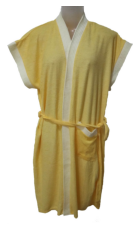

DESCRIPTION: Double color light yellow with white border Superiror Thailand


In [31]:
# text_desc = 'Double color light yellow with white border Superiror Thailand'
text_desc = 'Double color light yellow Thailand'
img_path = 'Images/gw10r05f0009-g-gotewala-bath-gown-original-imae6th5fgayppvz.jpeg'
is_listing_genuine(img_path, text_desc)